In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

In [2]:
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()
OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), 250)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]

Get out-of-sample scenarios

In [3]:
# Indices of all scenarios
all_indices = list(range(S))

# Indices of out-of-sample scenarios
out_of_sample_indices = list(set(all_indices) - set(in_sample_scenarios))

# Sample 950 out-of-sample scenarios without replacement
#out_sample_indices = random.sample(out_of_sample_indices, 950)
#print(out_sample_indices)

# Extract out-of-sample scenarios from the dictionary containing all scenarios
out_sample_scenarios = {}
for i, idx in enumerate(out_of_sample_indices):
    out_sample_scenarios[str(i)] = all_scenarios[str(idx)]
    out_sample_scenarios[str(i)]['Original Index'] = idx

# Print information
print('Number of out-of-sample scenarios:', len(out_sample_scenarios))

Number of out-of-sample scenarios: 1750


Import the optimal day-ahead dispatch values

In [4]:
optimal_DA_bids = pd.read_csv('Data/optimal_DA_bids.csv', index_col=0)

optimal_DA_oneprice = optimal_DA_bids['One-price Bids [MW]'].values
optimal_DA_twoprice = optimal_DA_bids['Two-price Bids [MW]'].values

Calculate out-of-sample performance **(one-price)**

In [5]:
out_sample_scenarios['0'].keys()

dict_keys(['Wind Power [MW]', 'Spot Price [EUR/MWh]', 'System Balance State', 'Original Index'])

In [14]:
# Calculate payments or earnings for out-of-sample scenarios
total_payment_earnings = 0
out_of_sample_profits = []

for scenario_idx in out_sample_scenarios:
    scenario = out_sample_scenarios[scenario_idx]

    x = scenario['Spot Price [EUR/MWh]'] * optimal_DA_oneprice

    realized_imbalance = np.array(scenario['Wind Power [MW]']) - optimal_DA_oneprice

    price_coefficient = 1.2 * np.array(scenario['System Balance State']) + 0.9 * (1 - np.array(scenario['System Balance State']))
    y = realized_imbalance * price_coefficient * scenario['Spot Price [EUR/MWh]']

    payment_earnings = x + y

    out_of_sample_profits.extend(payment_earnings)
    
    total_payment_earnings += np.sum(payment_earnings)

# Calculate average payment or earnings over out-of-sample scenarios
average_payment_earnings_one_price = total_payment_earnings / len(out_sample_scenarios)

print(average_payment_earnings_one_price)


183418.07733846846


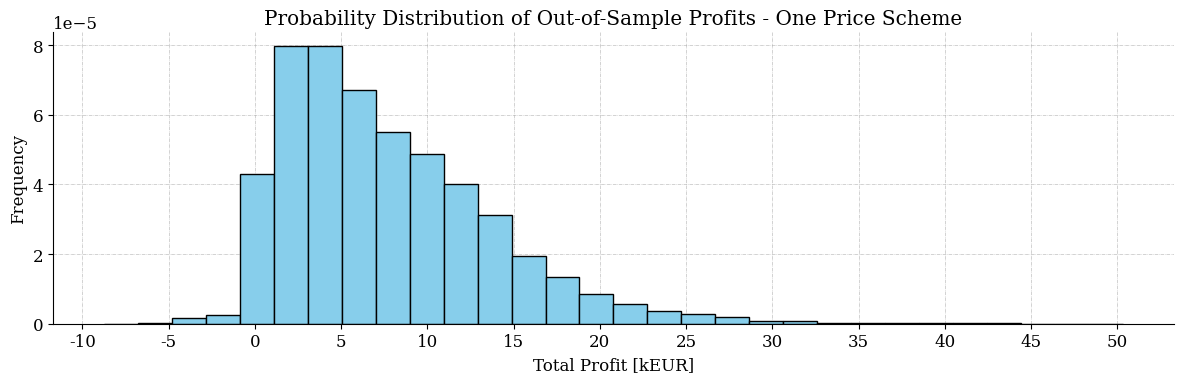

In [18]:
# Plot histogram of out-of-sample profits
fig = plt.figure(figsize=(12, 4))
plt.hist(out_of_sample_profits, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title('Probability Distribution of Out-of-Sample Profits - One Price Scheme')
plt.xlabel('Total Profit [kEUR]')
plt.ylabel('Frequency')
plt.xticks(np.arange(-10000,55000,5000), labels=np.arange(-10,55,5))
plt.grid(True)
plt.gca().set_axisbelow(True)
fig.tight_layout()
plt.savefig('Figures/PD out-sample OP.png', dpi=300, bbox_inches='tight')
plt.show()

Calculate out-of-sample performance **(two-price)**

In [17]:
# Calculate payments or earnings for out-of-sample scenarios
total_payment_earnings_tp = 0
out_of_sample_profits_tp = []

for scenario_idx in out_sample_scenarios:
    scenario = out_sample_scenarios[scenario_idx]

    x = scenario['Spot Price [EUR/MWh]'] * optimal_DA_twoprice

    realized_imbalance = np.array(scenario['Wind Power [MW]']) - optimal_DA_twoprice

    price_coefficients = np.zeros(T)

    for t in range(T):
        if (realized_imbalance[t] > 0) and (scenario['System Balance State'][t] == 0):
            price_coefficients[t] = 0.9
        elif (realized_imbalance[t] > 0) and (scenario['System Balance State'][t] == 1):
            price_coefficients[t] = 1.0
        elif (realized_imbalance[t] < 0) and (scenario['System Balance State'][t] == 0):
            price_coefficients[t] = -1.0
        elif (realized_imbalance[t] < 0) and (scenario['System Balance State'][t] == 1):
            price_coefficients[t] = -1.2
    

    y = np.abs(realized_imbalance) * price_coefficients * scenario['Spot Price [EUR/MWh]']

    payment_earnings_tp = x + y

    out_of_sample_profits_tp.extend(payment_earnings_tp)
    
    total_payment_earnings_tp += np.sum(payment_earnings_tp)

# Calculate average payment or earnings over out-of-sample scenarios
average_payment_earnings_two_price = total_payment_earnings_tp / len(out_sample_scenarios)

print(average_payment_earnings_two_price)


165895.04957318484


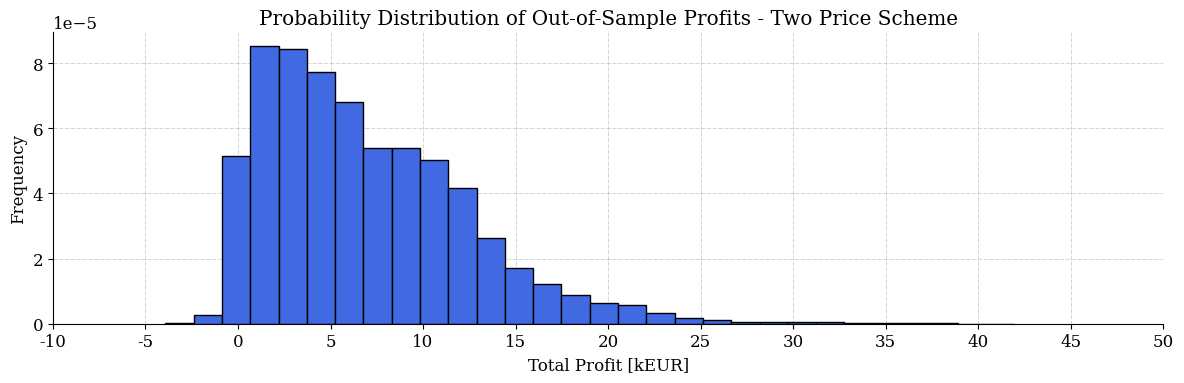

In [20]:
# Plot histogram of out-of-sample profits
fig = plt.figure(figsize=(12, 4))
plt.hist(out_of_sample_profits_tp, bins=30, density=True, color='royalblue', edgecolor='black')
plt.title('Probability Distribution of Out-of-Sample Profits - Two Price Scheme')
plt.xlabel('Total Profit [kEUR]')
plt.ylabel('Frequency')
plt.xticks(np.arange(-10000,55000,5000), labels=np.arange(-10,55,5))
plt.grid(True)
plt.gca().set_axisbelow(True)
fig.tight_layout()
plt.savefig('Figures/PD out-sample DP.png', dpi=300, bbox_inches='tight')
plt.show()